DATA VISUALISATION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('WaterQualityPrediction-Dataset.csv', sep=';')
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.sort_values(by=['date'])
numeric_columns = df.select_dtypes(include='number').columns
df[numeric_columns] = df[numeric_columns].interpolate()
df[numeric_columns] = df[numeric_columns].bfill().ffill()
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [2]:
def check_limits(row):
    return {
        'NH4_Status': 'Acceptable' if row['NH4'] < 0.5 else 'High',
        'BSK5_Status': 'Acceptable' if row['BSK5'] < 3 else 'High',
        'Suspended_Status': 'Acceptable' if row['Suspended'] < 25 else 'High',
        'O2_Status': 'Acceptable' if row['O2'] > 5 else 'Low',
        'NO3_Status': 'Acceptable' if row['NO3'] < 10 else 'High',
        'NO2_Status': 'Acceptable' if row['NO2'] < 0.1 else 'High',
        'SO4_Status': 'Acceptable' if row['SO4'] < 250 else 'High',
        'PO4_Status': 'Acceptable' if row['PO4'] < 0.1 else 'High',
        'CL_Status': 'Acceptable' if row['CL'] < 250 else 'High'
    }

limits_df = df.apply(lambda row: pd.Series(check_limits(row)), axis=1)
df_combined = pd.concat([df, limits_df], axis=1)

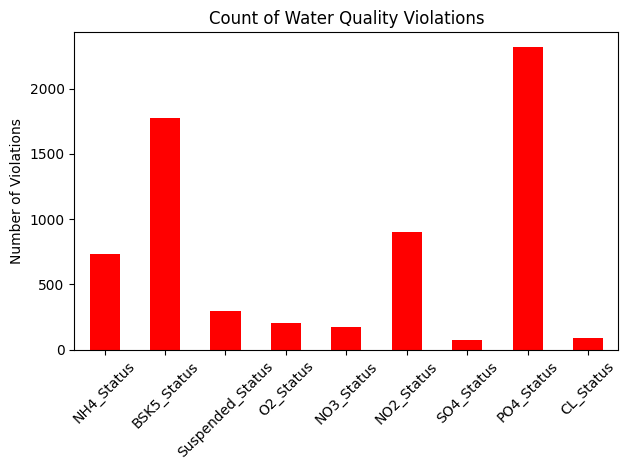

In [3]:
violation_counts = df_combined.filter(like='_Status').apply(lambda col: (col != 'Acceptable').sum())
violation_counts.plot(kind='bar', color='red')
plt.title('Count of Water Quality Violations')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

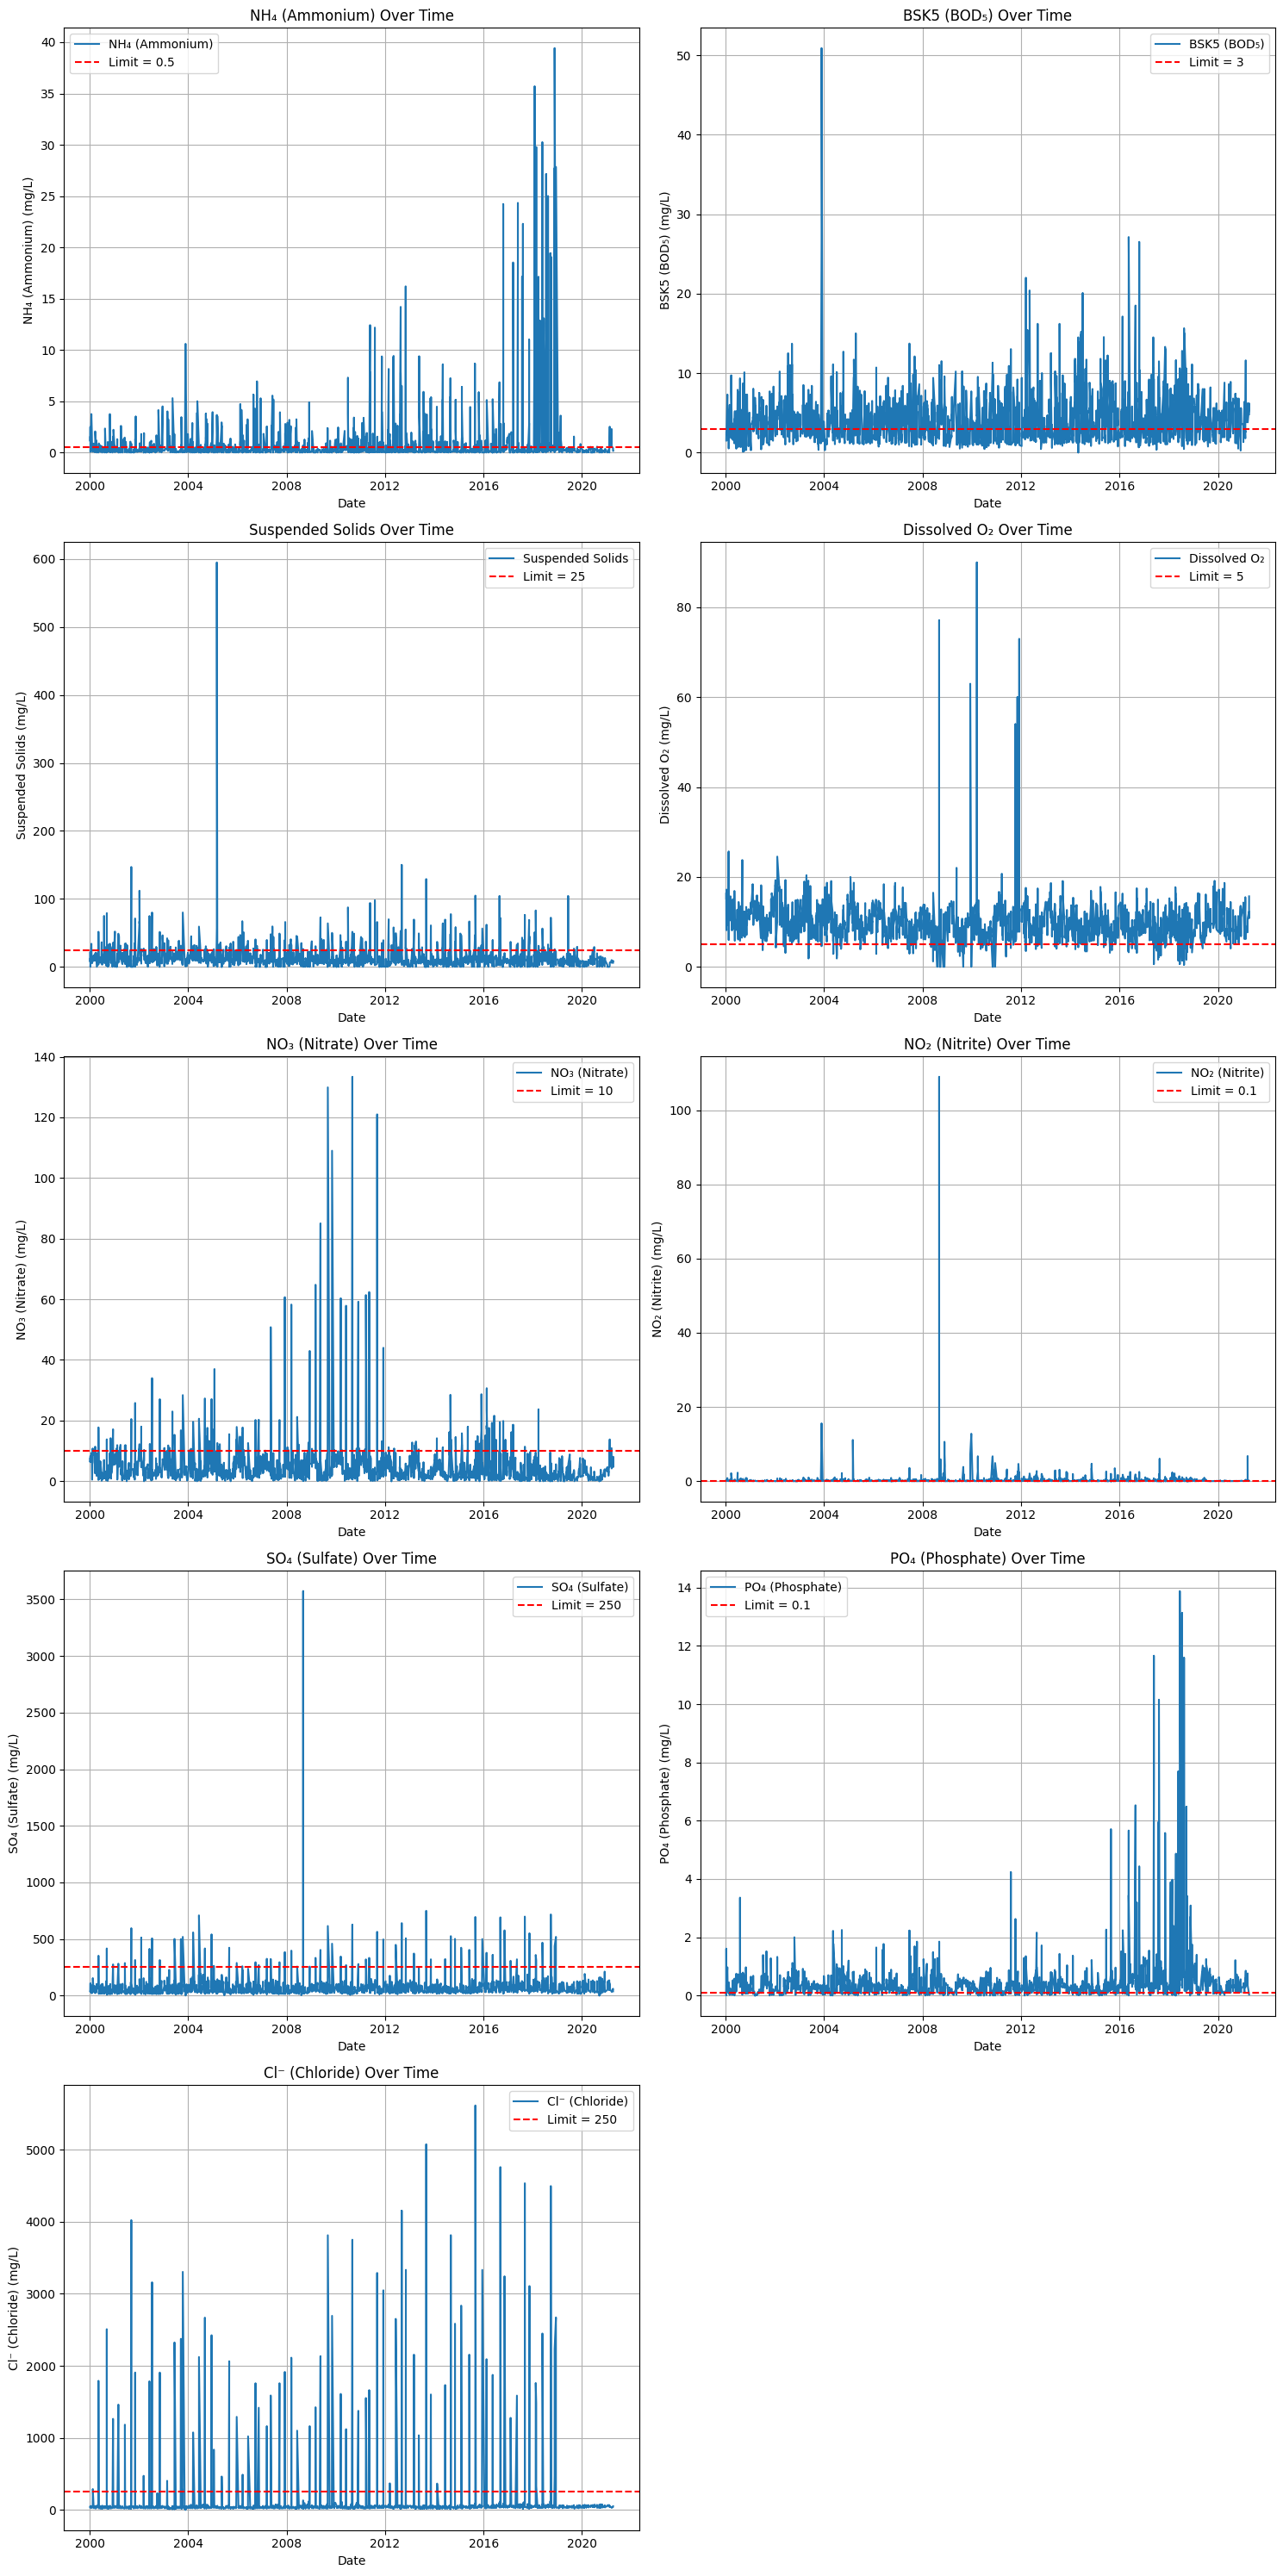

In [4]:
info = [
    ('NH4', 0.5, 'upper', 'NH₄ (Ammonium)'),
    ('BSK5', 3, 'upper', 'BSK5 (BOD₅)'),
    ('Suspended', 25, 'upper', 'Suspended Solids'),
    ('O2', 5, 'lower', 'Dissolved O₂'),
    ('NO3', 10, 'upper', 'NO₃ (Nitrate)'),
    ('NO2', 0.1, 'upper', 'NO₂ (Nitrite)'),
    ('SO4', 250, 'upper', 'SO₄ (Sulfate)'),
    ('PO4', 0.1, 'upper', 'PO₄ (Phosphate)'),
    ('CL', 250, 'upper', 'Cl⁻ (Chloride)')
]

plt.figure(figsize=(15, 30))
for idx, (col, limit, direction, label) in enumerate(info, 1):
    plt.subplot(5, 2, idx)
    plt.plot(df_combined['date'], df_combined[col], label=label)
    plt.axhline(limit, color='red', linestyle='--', label=f'Limit = {limit}')
    plt.title(f'{label} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{label} (mg/L)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

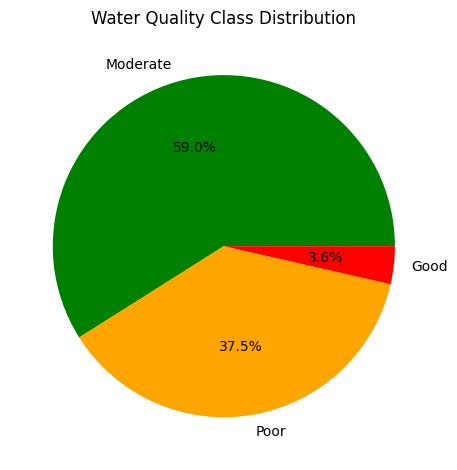

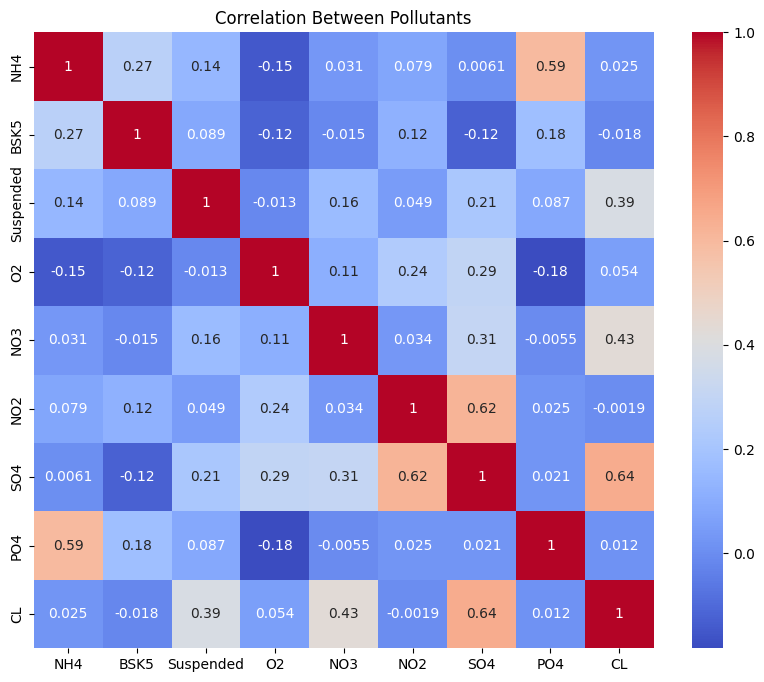

In [5]:
df_combined['Violations'] = df_combined.filter(like='_Status').apply(lambda row: sum(row != 'Acceptable'), axis=1)

def quality_class(v):
    if v == 0:
        return 'Good'
    elif v <= 2:
        return 'Moderate'
    else:
        return 'Poor'

df_combined['Quality_Class'] = df_combined['Violations'].apply(quality_class)

df_combined['Quality_Class'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange', 'red'])
plt.title('Water Quality Class Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_combined[['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutants')
plt.show()

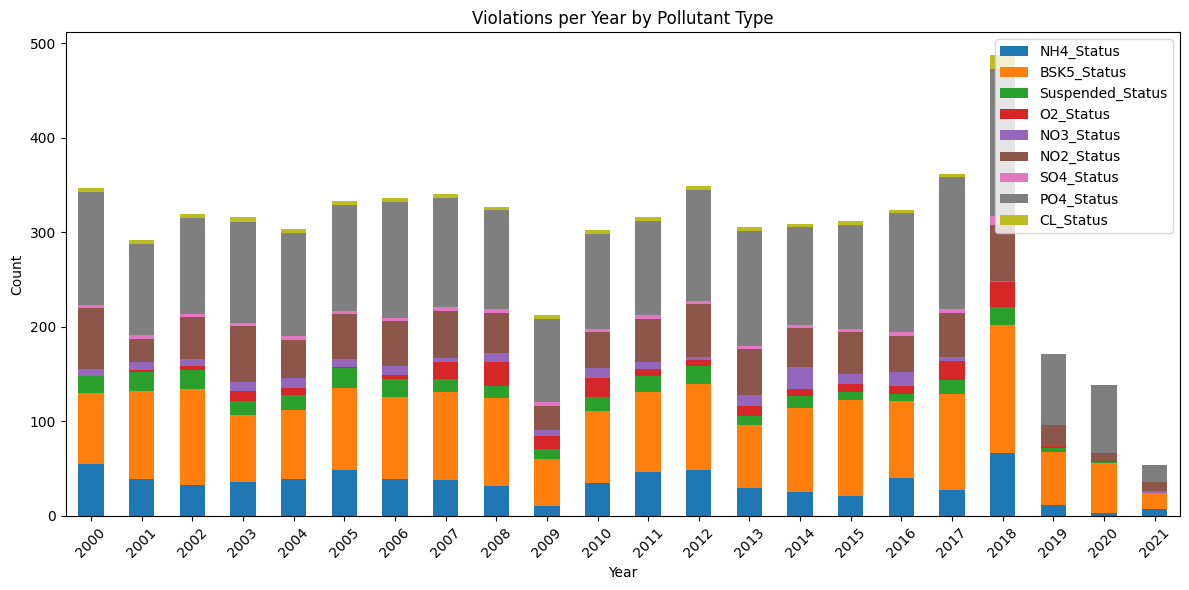

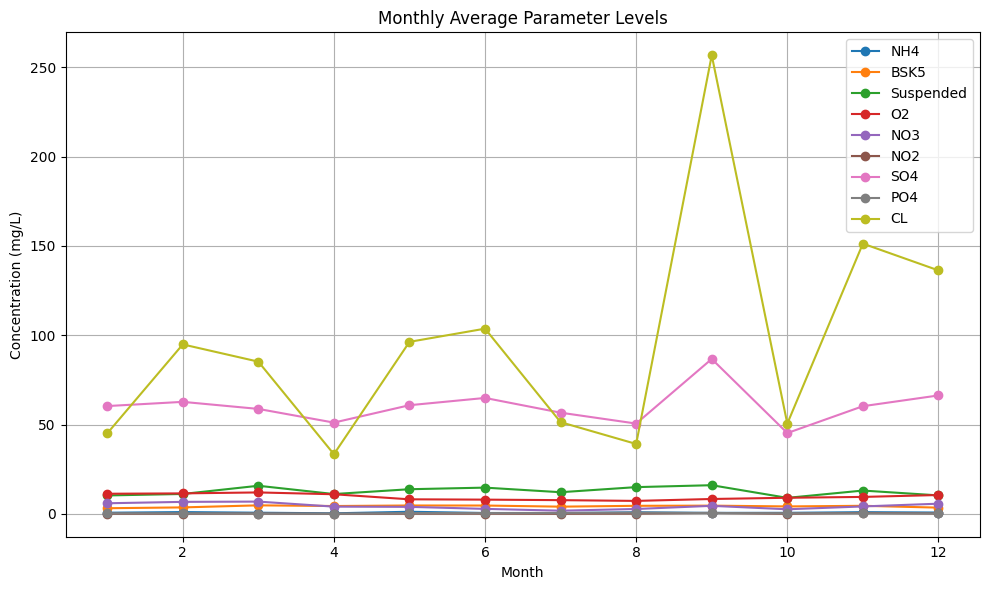

In [6]:
violations_by_year = df_combined.groupby(df_combined['date'].dt.year)[df_combined.filter(like='_Status').columns]
violation_counts_yearwise = violations_by_year.apply(lambda x: (x != 'Acceptable').sum())

violation_counts_yearwise.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Violations per Year by Pollutant Type')
plt.ylabel('Count')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_combined['Month'] = df_combined['date'].dt.month
monthly_avg = df_combined.groupby('Month')[['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']].mean()

monthly_avg.plot(kind='line', figsize=(10, 6), marker='o')
plt.title("Monthly Average Parameter Levels")
plt.ylabel("Concentration (mg/L)")
plt.grid(True)
plt.tight_layout()
plt.show()

df_combined.to_csv('WaterQualityPrediction-Processed.csv', index=False)

MACHINE LEARNING MODEL

In [7]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('WaterQualityPrediction-Dataset.csv', sep=';')
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['year'] = df['date'].dt.year
df = df.sort_values(by=['id', 'date'])

pollutants = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
df[pollutants] = df[pollutants].interpolate(method='linear')
df[pollutants] = df[pollutants].bfill()
df[pollutants] = df[pollutants].ffill()

X = df[['id', 'year']]
y = df[pollutants]
X_encoded = pd.get_dummies(X, columns=['id'], drop_first=True)

# 0: Good; 1: Moderate; 2: Poor
def label_quality(row):
    v = sum([
        row['NH4'] >= 0.5,
        row['BSK5'] >= 3,
        row['Suspended'] >= 25,
        row['O2'] <= 5,
        row['NO3'] >= 10,
        row['NO2'] >= 0.1,
        row['SO4'] >= 250,
        row['PO4'] >= 0.1,
        row['CL'] >= 250
    ])
    return 0 if v == 0 else (1 if v <= 2 else 2)

df['quality_class'] = df.apply(label_quality, axis=1)
y_class = df['quality_class']

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
_, X_test_class, _, y_test_class = train_test_split(X_encoded, y_class, test_size=0.2, random_state=42)

models = {
    'Random Forest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'Linear Regression': MultiOutputRegressor(LinearRegression()),
    'XGBoost': MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42)),
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)),
    'Neural Net': MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
}

base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]
final_model = RidgeCV()
models['Stacking'] = MultiOutputRegressor(StackingRegressor(estimators=base_models, final_estimator=final_model, passthrough=True))

for name, model in models.items():
    print(f"\n{name} Model Performance:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    quality_preds = []
    for row in y_pred:
        v = sum([
            row[0] >= 0.5,
            row[1] >= 3,
            row[2] >= 25,
            row[3] <= 5,
            row[4] >= 10,
            row[5] >= 0.1,
            row[6] >= 250,
            row[7] >= 0.1,
            row[8] >= 250
        ])
        label = 0 if v == 0 else (1 if v <= 2 else 2)
        quality_preds.append(label)

    accuracy = accuracy_score(y_test_class, quality_preds)
    print(f"  Quality Class Accuracy: {accuracy:.3f}")

    for i, pollutant in enumerate(pollutants):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f'  {pollutant}: MSE = {mse:.3f}, R² = {r2:.3f}')


Random Forest Model Performance:
  Quality Class Accuracy: 0.738
  NH4: MSE = 2.142, R² = 0.786
  BSK5: MSE = 7.852, R² = 0.276
  Suspended: MSE = 256.048, R² = -1.208
  O2: MSE = 22.793, R² = 0.011
  NO3: MSE = 17.764, R² = 0.519
  NO2: MSE = 5.674, R² = -6.466
  SO4: MSE = 2665.675, R² = 0.327
  PO4: MSE = 0.446, R² = 0.352
  CL: MSE = 34924.446, R² = 0.727

Gradient Boosting Model Performance:
  Quality Class Accuracy: 0.651
  NH4: MSE = 2.156, R² = 0.785
  BSK5: MSE = 7.380, R² = 0.319
  Suspended: MSE = 208.962, R² = -0.802
  O2: MSE = 20.643, R² = 0.104
  NO3: MSE = 33.427, R² = 0.096
  NO2: MSE = 0.706, R² = 0.071
  SO4: MSE = 2929.552, R² = 0.260
  PO4: MSE = 0.402, R² = 0.417
  CL: MSE = 117741.384, R² = 0.080

Linear Regression Model Performance:
  Quality Class Accuracy: 0.627
  NH4: MSE = 5.883, R² = 0.412
  BSK5: MSE = 7.778, R² = 0.283
  Suspended: MSE = 103.969, R² = 0.104
  O2: MSE = 20.656, R² = 0.103
  NO3: MSE = 24.757, R² = 0.330
  NO2: MSE = 0.721, R² = 0.051
  SO

In [9]:
import joblib
joblib.dump(models['Stacking'], 'stacking_prediction_model.pkl')
print("Stacking model saved as 'stacking_prediction_model.pkl'")
joblib.dump(X_encoded.columns.tolist(), "columns.pkl")
print("Feature columns saved as 'columns.pkl'")

Stacking model saved as 'stacking_prediction_model.pkl'
Feature columns saved as 'columns.pkl'


<Figure size 1600x800 with 0 Axes>

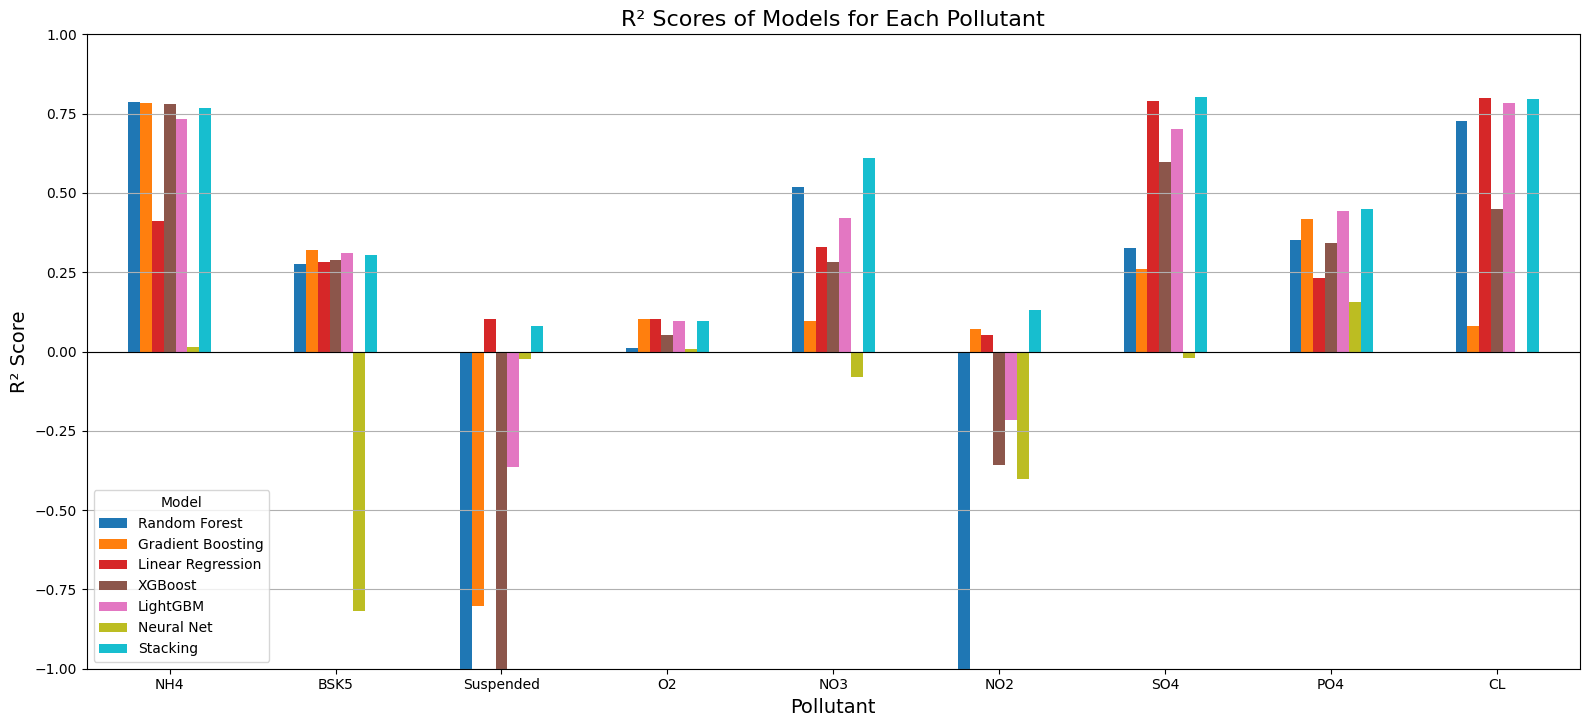

<Figure size 1600x800 with 0 Axes>

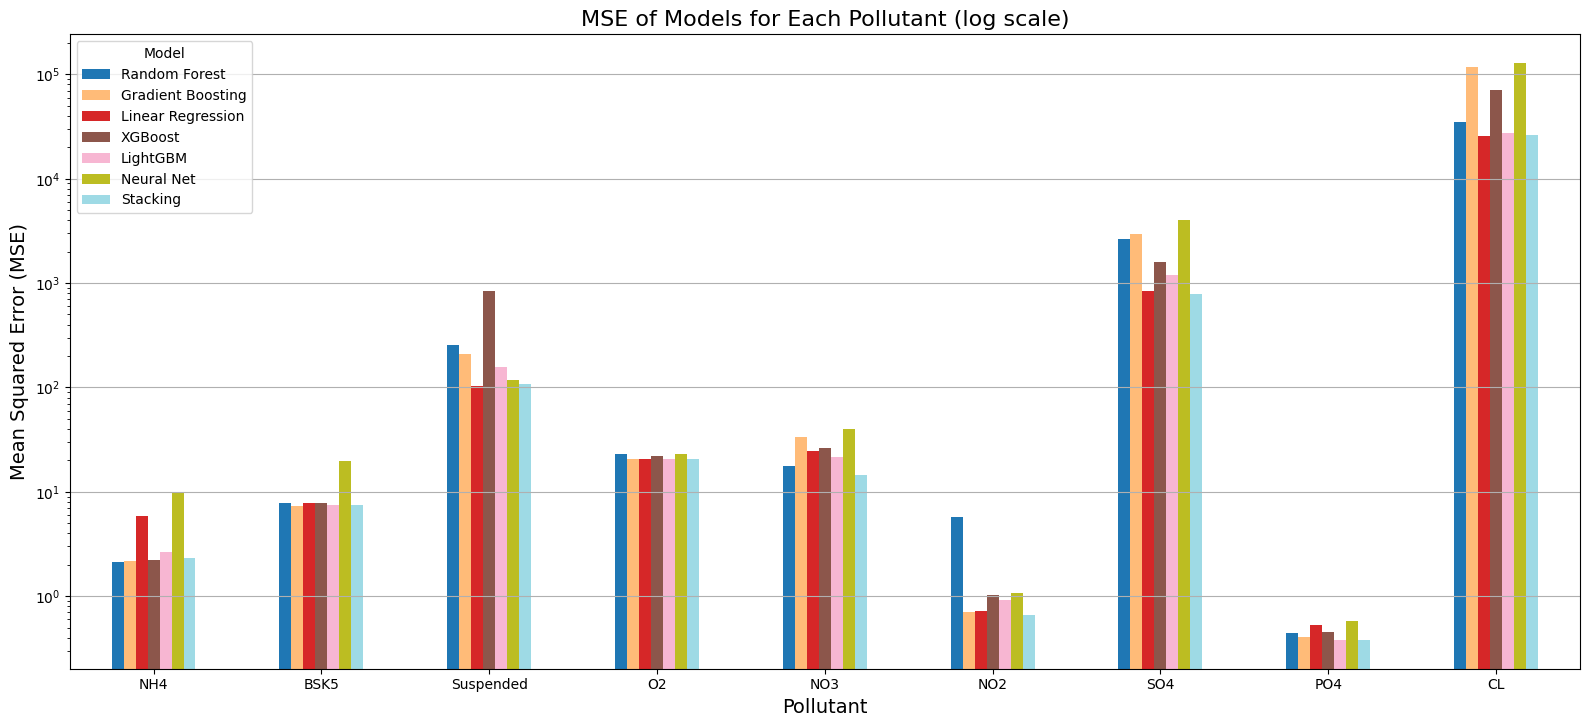

In [10]:
# MODEL PERFORMANCE VISUALISATION
r2_scores = {
    'Random Forest': [0.786, 0.276, -1.208, 0.011, 0.519, -6.466, 0.327, 0.352, 0.727],
    'Gradient Boosting': [0.785, 0.319, -0.802, 0.104, 0.096, 0.071, 0.260, 0.417, 0.080],
    'Linear Regression': [0.412, 0.283, 0.104, 0.103, 0.330, 0.051, 0.789, 0.233, 0.800],
    'XGBoost': [0.780, 0.288, -6.308, 0.053, 0.282, -0.359, 0.597, 0.342, 0.450],
    'LightGBM': [0.733, 0.310, -0.365, 0.096, 0.420, -0.216, 0.700, 0.442, 0.784],
    'Neural Net': [0.013, -0.818, -0.025, 0.007, -0.081, -0.402, -0.019, 0.157, 0.000],
    'Stacking': [0.769, 0.305, 0.080, 0.097, 0.610, 0.130, 0.803, 0.448, 0.797]
}

df_r2 = pd.DataFrame(r2_scores, index=pollutants)

plt.figure(figsize=(16, 8))
df_r2.plot(kind='bar', figsize=(16, 8), colormap='tab10')
plt.title('R² Scores of Models for Each Pollutant', fontsize=16)
plt.xlabel('Pollutant', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.ylim(-1, 1)
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=0)
plt.show()

mse_scores = {
    'Random Forest': [2.142, 7.852, 256.048, 22.793, 17.764, 5.674, 2665.675, 0.446, 34924.446],
    'Gradient Boosting': [2.156, 7.380, 208.962, 20.643, 33.427, 0.706, 2929.552, 0.402, 117741.384],
    'Linear Regression': [5.883, 7.778, 103.969, 20.656, 24.757, 0.721, 833.945, 0.528, 25604.381],
    'XGBoost': [2.199, 7.725, 847.518, 21.810, 26.540, 1.033, 1597.263, 0.453, 70424.550],
    'LightGBM': [2.678, 7.483, 158.264, 20.819, 21.451, 0.924, 1189.189, 0.384, 27625.684],
    'Neural Net': [9.879, 19.712, 118.896, 22.869, 39.952, 1.065, 4035.654, 0.581, 127973.259],
    'Stacking': [2.317, 7.532, 106.734, 20.792, 14.413, 0.661, 778.078, 0.381, 25945.159]
}

df_mse = pd.DataFrame(mse_scores, index=pollutants)
plt.figure(figsize=(16, 8))
df_mse.plot(kind='bar', figsize=(16, 8), colormap='tab20')
plt.title('MSE of Models for Each Pollutant (log scale)', fontsize=16)
plt.xlabel('Pollutant', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.yscale('log')
plt.grid(axis='y')
plt.legend(title='Model')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [11]:
station_id = '22'
year_input = 2022

input_data = pd.DataFrame({'year': [year_input], 'id': [station_id]})
input_encoded = pd.get_dummies(input_data, columns=['id'])

missing_cols = set(X_encoded.columns) - set(input_encoded.columns)
for col in missing_cols:
    input_encoded[col] = 0
input_encoded = input_encoded[X_encoded.columns]

predicted_pollutants = models['Stacking'].predict(input_encoded)[0]

print(f"\nPredicted pollutant levels for station '{station_id}' in {year_input}:")
for p, val in zip(pollutants, predicted_pollutants):
    print(f"  {p}: {val:.4f}")


Predicted pollutant levels for station '22' in 2022:
  NH4: 0.1350
  BSK5: 2.2905
  Suspended: 4.9190
  O2: 11.8664
  NO3: 3.8470
  NO2: 0.0471
  SO4: 129.1621
  PO4: 0.4941
  CL: 93.0953
